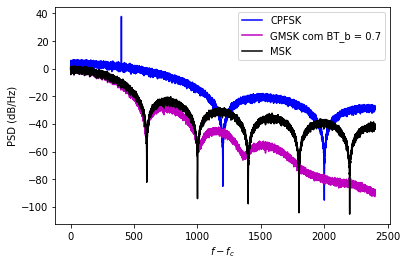

In [1]:
#plotar os 3 psd
import numpy as np
from scipy.signal import upfirdn,lfilter
import matplotlib.pyplot as plt
def gaussianLPF(BT, Tb, L, k):
  """
  BT : BT product - Bandwidth x bit period
  Tb : bit period
  L : oversampling factor (number of samples per bit)
  k : span length of the pulse (bit interval)
  Returns:
  h_norm : normalized filter coefficients of Gaussian LPF
  """
  B = BT/Tb # bandwidth of the filter
  # truncated time limits for the filter
  t = np.arange(start = -k*Tb, stop = k*Tb + Tb/L, step = Tb/L)
  h = B*np.sqrt(2*np.pi/(np.log(2)))*np.exp(-2 * (t*np.pi*B)**2 /(np.log(2)))
  h_norm=h/np.sum(h)
  return h_norm

def gmsk_mod(a,fc,L,BT,enable_plot=False):
    """
    Function to modulate a binary stream using GMSK modulation
    Parameters:
        BT : BT product (bandwidth x bit period) for GMSK
        a : input binary data stream (0's and 1's) to modulate
        fc : RF carrier frequency in Hertz
        L : oversampling factor
        enable_plot: True = plot transmitter waveforms (default False)
    Returns:
        (s_t,s_complex) : tuple containing the following variables
            s_t : GMSK modulated signal with carrier s(t)
            s_complex : baseband GMSK signal (I+jQ)
    """ 
    fs = L*fc; Ts=1/fs;Tb = L*Ts; # derived waveform timing parameters
    c_t = upfirdn(h=[1]*L, x=2*a-1, up = L) #NRZ pulse train c(t)
    
    k=1 # truncation length for Gaussian LPF
    h_t = gaussianLPF(BT,Tb,L,k) # Gaussian LPF with BT=0.25
    b_t = np.convolve(h_t,c_t,'full') # convolve c(t) with Gaussian LPF to get b(t)
    bnorm_t = b_t/max(abs(b_t)) # normalize the output of Gaussian LPF to +/-1
    
    h = 0.5;
    # integrate to get phase information
    phi_t = lfilter(b = [1], a = [1,-1], x = bnorm_t*Ts) * h*np.pi/Tb 
    
    I = np.cos(phi_t)
    Q = np.sin(phi_t) # cross-correlated baseband I/Q signals
    
    s_complex = I - 1j*Q # complex baseband representation
    t = Ts* np.arange(start = 0, stop = len(I)) # time base for RF carrier
    sI_t = I*np.cos(2*np.pi*fc*t); sQ_t = Q*np.sin(2*np.pi*fc*t)
    s_t = sI_t - sQ_t # s(t) - GMSK with RF carrier
    
    if enable_plot:
        fig, axs = plt.subplots(2, 4)
        axs[0,0].plot(np.arange(0,len(c_t))*Ts,c_t);
        axs[0,0].set_title('c(t)');axs[0,0].set_xlim(0,40*Tb)
        axs[0,1].plot(np.arange(-k*Tb,k*Tb+Ts,Ts),h_t);
        axs[0,1].set_title('$h(t): BT_b$='+str(BT))
        axs[0,2].plot(t,I,'--');axs[0,2].plot(t,sI_t,'r');
        axs[0,2].set_title('$I(t)cos(2 \pi f_c t)$');axs[0,2].set_xlim(0,10*Tb)
        axs[0,3].plot(t,Q,'--');axs[0,3].plot(t,sQ_t,'r');
        axs[0,3].set_title('$Q(t)sin(2 \pi f_c t)$');axs[0,3].set_xlim(0,10*Tb)
        axs[1,0].plot( np.arange(0,len(bnorm_t))*Ts,bnorm_t);
        axs[1,0].set_title('b(t)');axs[1,0].set_xlim(0,40*Tb)
        axs[1,1].plot(np.arange(0,len(phi_t))*Ts, phi_t);
        axs[1,1].set_title('$\phi(t)$')
        axs[1,2].plot(t,s_t);axs[1,2].set_title('s(t)');
        axs[1,2].set_xlim(0,20*Tb)
        axs[1,3].plot(I,Q);axs[1,3].set_title('Constelação')
        fig.show()        
    return (s_t,s_complex)

def plotWelchPSD(x,fs,fc,ax = None,color='b', label=None):
   
    from scipy.signal import hanning, welch
    from numpy import log10
    from scipy.signal.windows import hann
    nx = max(x.shape)
    na = 16 # averaging factor to plot averaged welch spectrum
    w = hann(nx//na) #// is for integer floor division
    # Welch PSD estimate with Hanning window and no overlap
    f, Pxx = welch(x,fs,window = w,noverlap=0)
    indices = (f>=fc) & (f<4*fc)   # To plot PSD from Fc to 4*Fc
    Pxx = Pxx[indices]/Pxx[indices][0] # normalized psd w.r.t Fc
    ax.plot(f[indices]-fc,10*log10(Pxx),color,label=label) #Plot in the given axes

N = 100000 # Number of symbols to transmit
fc = 800 # carrier frequency in Hertz
L = 16 # oversampling factor,use L= Fs/Fc, where Fs >> 2xFc
fs = L*fc
a = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
(s3 , _ ) = gmsk_mod(a,fc,L,BT=0.7) # BT_b=0.7
(s4 , _ ) = gmsk_mod(a,fc,L,BT=10000) # BT_b=very value value (MSK)
# Compute and plot PSDs for each of the modulated versions

#modulação CPFSK
i=0
while i < len(a):
   if a[i] == 0:
      a[i] = -1
   i=i+1
Tb=L/fs
a = np.tile(a, (L,1)).flatten('F')
a_integrated = lfilter([1.0],[1.0,-1.0],a)/fs
theta= np.pi/Tb*a_integrated
t=np.arange(0, Tb*N, 1/fs)
s_c = np.cos(2*np.pi*fc*t + theta)

fig, ax = plt.subplots(1, 1)
plotWelchPSD(s_c,fs,fc, ax = ax , color = 'b', label = 'CPFSK')
plotWelchPSD(s3,fs,fc, ax = ax , color = 'm', label = 'GMSK com BT_b = 0.7')
plotWelchPSD(s4,fs,fc, ax = ax , color = 'k', label = 'MSK')
ax.set_xlabel('$f-f_c$'); ax.set_ylabel('PSD (dB/Hz)')
ax.legend(); fig.show()